# Analysis Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['lines.linewidth'] = 2.5

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
results_dir = Path("results")
results_paths = results_dir.glob("*.json")

results = []
for path in results_paths:
    results.append(pd.read_json(path, orient='index').T)
results_df = pd.concat(results, axis=0).reset_index()

In [4]:
data_names = results_df["data_name"].unique()

In [5]:
def plot_metric_for_name(data_name, metric_name, ax=None, remove_drop=False):
    if ax is None:
        fig, ax = plt.subplots()
    results_data_name = results_df[results_df["data_name"] == data_name]

    info_first = results_data_name.iloc[0]
    data_name = info_first['data_name']
    results_data_name_sorted = results_data_name.sort_values(f"test_{metric_name}_mean")
    null_encoders = ~results_data_name_sorted[f"test_{metric_name}_mean"].isna()
    if remove_drop:
        null_encoders &= (results_data_name_sorted["encoder"] != "drop")
    y_values = np.arange(np.sum(null_encoders))
        
    ax.errorbar(results_data_name_sorted.loc[null_encoders, f"test_{metric_name}_mean"],
                y_values,
                xerr=results_data_name_sorted.loc[null_encoders, f"test_{metric_name}_std"],
                ls='', marker='o')
    ax.set_yticks(y_values)
    ax.set_yticklabels(results_data_name_sorted.loc[null_encoders, "encoder"])
    ax.set_title(f"{data_name}: {metric_name}")

In [6]:
def plot_all_metrics(data_name, remove_drop=False):
    results_data_name = results_df[results_df["data_name"] == data_name]
    info_first = results_data_name.iloc[0]
    
    non_null_names = info_first.notnull()
    test_names = info_first.index.str.startswith("test")
    score_names = info_first.index[non_null_names & test_names]
    score_means_names = score_names[score_names.str.endswith("_mean")]
    
    metric_names = [name[5:-5] for name in score_means_names]
    
    fig, axes = plt.subplots(1, len(metric_names), figsize=(20, 6), constrained_layout=True)
    
    for metric_name, ax in zip(metric_names, axes.flatten()):
        plot_metric_for_name(data_name, metric_name, ax=ax, remove_drop=remove_drop)

In [7]:
data_names

array(['taxi', 'phishing_websites', 'ames', 'adult', 'churn',
       'dresses_sales', 'telco', 'amazon_access', 'kicks'], dtype=object)

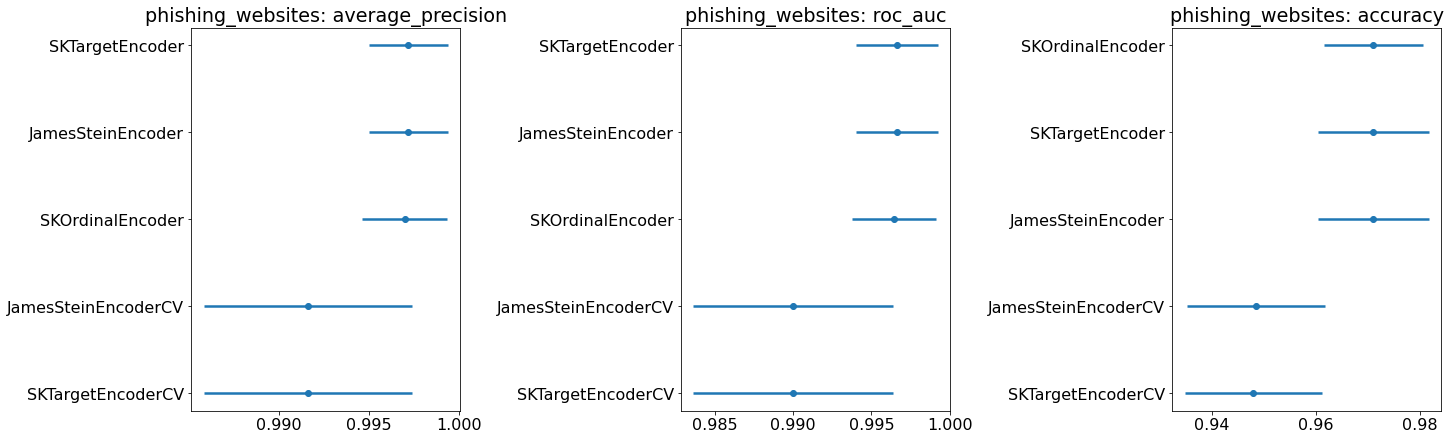

In [8]:
plot_all_metrics("phishing_websites")

## Get metadata for datasets

In [1]:
from bench_utils import fetch_openml_and_clean
from benchmark import DATA_INFOS

In [2]:
data_info = DATA_INFOS['kicks']

In [5]:
def get_metadata(data_info):
    X, y = fetch_openml_and_clean(data_info)
    data_info.is_classification
    n_cats = X.select_dtypes(include=['object', 'category']).shape[1]
    n_samples, n_features = X.shape
    
    return {'dataset_name': data_info.data_name,
            'categorical feaatures': n_cats,
            'n_features': n_features,
            'n_samples': n_samples,
            'is_classification': data_info.is_classification,
            'openml_url': f'https://www.openml.org/d/{data_info.data_id}'}

In [9]:
all_metadata = [get_metadata(data_info) for data_info in DATA_INFOS.values()]

fetching and loading kicks dataset from openml
fetching and loading amazon_access dataset from openml
fetching and loading telco dataset from openml
fetching and loading adult dataset from openml
fetching and loading ames dataset from openml
fetching and loading taxi dataset from openml
fetching and loading churn dataset from openml
fetching and loading dresses_sales dataset from openml
fetching and loading phishing_websites dataset from openml


In [11]:
import pandas as pd
metadata_df = pd.DataFrame.from_records(all_metadata)

In [16]:
print(metadata_df.to_markdown())

|    | dataset_name      |   categorical feaatures |   n_features |   n_samples | is_classification   | openml_url                     |
|---:|:------------------|------------------------:|-------------:|------------:|:--------------------|:-------------------------------|
|  0 | kicks             |                      18 |           32 |       72983 | True                | https://www.openml.org/d/41162 |
|  1 | amazon_access     |                       9 |            9 |       32769 | True                | https://www.openml.org/d/4135  |
|  2 | telco             |                      16 |           19 |        7043 | True                | https://www.openml.org/d/42178 |
|  3 | adult             |                      12 |           14 |       48842 | True                | https://www.openml.org/d/179   |
|  4 | ames              |                      43 |           79 |        1460 | False               | https://www.openml.org/d/42165 |
|  5 | taxi              |               